In [51]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../mermaid'))

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg
ds = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./files/",
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=500
)
import numpy as np
images = []
for _, batch in enumerate(ds):
    label = np.array(batch[1])
    batch_nines = label==3
    images.append(np.array(batch[0])[batch_nines])
images = np.concatenate(images)

ds = torch.utils.data.TensorDataset(torch.Tensor(images))
d1, d2 = (torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True, ) for _ in (1,1))



In [105]:
import matplotlib.pyplot as plt

In [106]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.dropout(F.relu(self.conv1(x)))], 1)
        x = torch.cat([x, F.dropout(F.relu(self.conv2(x)))], 1)
        x = torch.cat([x, F.dropout(F.relu(self.conv3(x)))], 1)
        x = torch.cat([x, F.dropout(F.relu(self.conv4(x)))], 1)
        x = torch.cat([x, F.dropout(F.relu(self.conv5(x)))], 1)
        
        return self.conv6(x)


class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        parameters = pars.ParameterDict()
        parameters.load_JSON("mermaid_config2.json")
        self.sz = np.array([128, 1, 28, 28])
        self.spacing = 1./(self.sz[2::]-1) 
        mf = py_mf.ModelFactory(self.sz, self.spacing, self.sz, self.spacing)
        net, loss = mf.create_registration_model(
            'lddmm_shooting_map', parameters["model"])
        net.computer_inverse_map = True
        loss.add_similarity_measure("ssd", smf.SSDSimilarity)

        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
        self.mermaid_unit = net.cuda()
        self.mermaid_loss = loss
        
        self.regis_net = RegisNet().cuda()
        

    def forward(self, moving_image, fixed_image):
        
        #modify self.mermaid_unit.m here
        m = self.regis_net(moving_image, fixed_image)
        self.mermaid_unit.m = m
        self.mermaid_loss.m = m
        
        #this call modifies self.phi
        self.warped_moving_image = self.__mermaid_shoot__(moving_image)
        
        all_loss, sim_loss, reg_loss = self.mermaid_loss(
            self.identityMap, 
            self.phi,
            moving_image,
            fixed_image,
            None,
            variables_from_forward_model=self.mermaid_unit.get_variables_to_transfer_to_loss_function(),
            variables_from_optimizer=None
        )
        self.loss_dict = {
            'all_loss': all_loss / self.sz[0],
            'sim_loss': sim_loss / self.sz[0],
            'reg_loss': reg_loss / self.sz[0]
        }

    def __mermaid_shoot__(self, moving_image):
        self.phi=self.mermaid_unit(self.identityMap, moving_image)
        warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, 
            self.phi,
            self.spacing,
            spline_order=1
        )
        return warped_moving_image



net = MermaidNet()
0

Loading parameter file = mermaid_config2.json
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Using map-based lddmm_shooting_map model
Using default value = True for key = use_CFL_clamping of category = root.model.registration_model
Using default value = False for key = use_ode_tuple of category = root.model.registration_model.env
the param of smoother is <mermaid.smoother_factory.MultiGaussianFourierSmoother object at 0x7fea90b5ad90>
Creating new category: root.model.registration_model.loss
Using default value = False for key = display_max_displacement of category = root.model.registration_model.loss
Using default value = False for key = limit_displacement of category = root.model.registration_model.loss
Using default value = 0.05 for key = max_displacement of category = root.model.registration_model.loss
Registering new similarity measure ssd in factory


0

In [107]:
optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

In [108]:
net.train()

MermaidNet(
  (mermaid_unit): LDDMMShootingVectorMomentumMapNet(
    (integrator): ODEWrapBlock()
  )
  (mermaid_loss): LDDMMShootingVectorMomentumMapLoss()
  (regis_net): RegisNet(
    (conv1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(22, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(32, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5): Conv2d(42, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv6): Conv2d(52, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [115]:
for _ in range(40):
    for moving, fixed in list(zip(d1, d2)):
        if moving[0].size()[0] == 128:
            moving_image = moving[0].cuda()
            fixed_image = fixed[0].cuda()
            optimizer.zero_grad()
            net(moving_image, fixed_image)
            loss = net.loss_dict["all_loss"]
            print(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()


/media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/torchdiffeq/_impl/misc.py:81: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.1}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


[3.6715848]
[3.5007808]
[3.9465952]
[3.6671913]
[4.0081277]
[3.7230906]
[3.7089531]
[3.7169821]
[3.870966]
[3.7918236]
[3.9235172]
[3.7691019]
[3.6998124]
[3.8489256]
[3.8560572]
[3.6661687]
[4.007972]
[3.7857282]
[4.121061]
[3.9013538]
[3.5297296]
[3.7957394]
[3.565545]
[3.80156]
[3.9243507]
[4.0345]
[3.4690332]
[3.7317312]
[4.0030575]
[3.8958812]
[3.5706794]
[3.8315785]
[3.635106]
[4.0142236]
[3.8341286]
[3.872638]
[3.864288]
[3.6047883]
[3.888159]
[3.9161446]
[3.6830397]
[3.9047606]
[3.9698274]
[3.6205273]
[3.7375767]
[3.7882018]
[3.9167907]
[3.702059]
[3.69471]
[3.7899392]
[3.5382428]
[3.6489635]
[3.601833]
[3.584471]
[3.7579827]
[3.8321319]
[3.7539542]
[3.4660616]
[3.710163]
[3.5727084]
[3.672602]
[4.168233]
[3.7275574]
[3.658877]
[3.521377]
[3.7092748]
[3.6097093]
[3.6189404]
[3.5678291]
[3.783293]
[3.592184]
[3.5776727]
[3.6306794]
[3.7053287]
[3.4903646]
[3.655026]
[3.5889475]
[3.7095916]
[3.6277995]
[3.8385153]
[3.7186463]
[3.5997186]
[3.7154067]
[3.7817903]
[3.6062865]
[3.661

[2.9278555]
[2.7748456]
[2.914063]
[2.8898811]
[2.8655033]
[2.9656258]
[2.8306456]
[2.978708]
[3.16971]
[2.8945894]
[3.077152]
[2.7961931]
[3.0451787]
[2.979618]
[2.8188455]
[2.8987918]
[3.0186691]
[3.0668206]
[3.08701]
[2.8704617]
[2.9276934]
[2.7884858]
[3.2356422]
[3.1236541]
[2.9418616]
[3.002895]
[2.763343]
[3.1440337]
[2.6934564]
[3.0050914]
[2.813311]
[2.8789313]
[2.9701054]
[3.063217]
[3.060183]
[3.1859066]
[3.0026076]
[2.849131]
[2.8982537]
[3.1951573]
[2.9589078]
[2.73577]
[3.0013838]
[2.9041889]
[2.8217382]
[2.6851666]
[3.1229992]
[2.9364905]
[2.7751946]
[2.7707486]
[2.9563577]
[2.7407134]
[3.0446336]
[2.914716]
[2.9577742]
[2.920598]
[2.824845]
[2.9152274]
[2.8433387]
[3.0246987]
[2.9608104]
[2.9382758]
[2.9880307]
[2.7363653]
[2.9265327]
[3.0318754]
[2.850708]
[2.8349202]
[3.1141837]
[2.9683425]
[2.920524]
[3.0614572]
[3.0663366]
[2.811688]
[2.9870515]
[2.8165867]
[2.870176]
[2.8169081]
[2.726368]
[3.0360773]
[3.1679187]
[3.1208785]
[3.141997]
[3.037214]
[3.1255927]
[2.943

[2.6882954]
[2.536984]
[2.5908585]
[2.5806]
[2.644733]
[2.4482358]
[2.4235642]
[2.4386501]
[2.45217]
[2.502972]
[2.604296]
[2.3504198]
[2.4266243]
[2.6487486]
[2.504529]
[2.5551932]
[2.4288945]
[2.5635326]
[2.4064074]
[2.65562]
[2.5759776]
[2.5610094]
[2.320632]
[2.6238434]
[2.627947]
[2.3833687]
[2.5864842]
[2.548498]
[2.2296484]
[2.573167]
[2.575565]
[2.4241028]
[2.592654]
[2.4145231]
[2.4048746]
[2.5519526]
[2.6548371]
[2.4045641]
[2.5443962]
[2.6719866]
[2.2447407]
[2.632085]
[2.4742665]
[2.5715935]
[2.6490796]
[2.6664972]
[2.626585]
[2.427355]
[2.771696]
[2.3893847]
[2.61082]
[2.6315908]
[2.5137012]
[2.4919357]
[2.448134]
[2.5132577]
[2.5235312]
[2.546165]
[2.4541698]
[2.5406003]
[2.4772432]
[2.6632788]
[2.4297507]
[2.500224]
[2.4703176]
[2.5705755]
[2.6035738]
[2.482494]
[2.6758623]
[2.4534903]
[2.618707]
[2.6364725]
[2.4426134]
[2.5723715]
[2.5811229]
[2.5060787]
[2.9087708]
[2.4092116]
[2.383852]
[2.6094286]
[2.6336224]
[2.2281673]
[2.5151412]
[2.37045]
[2.3482022]
[2.558649]
[

KeyboardInterrupt: 

In [116]:
phi = np.array((net.phi).cpu().detach())
iden = np.array(net.identityMap.cpu())

In [117]:
iden.shape

(128, 2, 28, 28)

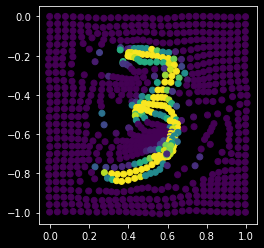

In [121]:
N = 81
plt.style.use("dark_background")
l = 0
a = l * iden + (1 - l) * phi
plt.axes().set_aspect('equal')
plt.scatter(a[N][1].flatten(), -a[N][0].flatten(), 
            c=fixed_image[N, 0].cpu().numpy().flatten())

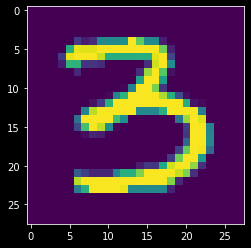

In [122]:
plt.imshow(fixed_image[N, 0].cpu().numpy())

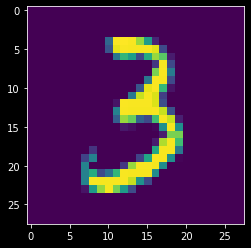

In [120]:
plt.imshow(moving_image[N, 0].cpu().numpy())

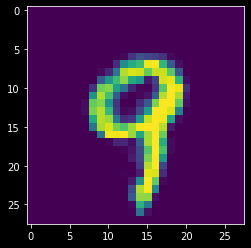

In [88]:
plt.imshow(net.warped_moving_image[N, 0].detach().cpu())

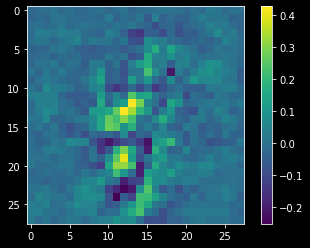

In [89]:
plt.imshow(net.mermaid_unit.m[N, 0].cpu().detach())
plt.colorbar()

In [99]:
def get_phi(a, b):
    net(a, b)
    return net.phi.detach().cpu()

In [100]:
phi1 = get_phi(moving_image, fixed_image)
phi2 = get_phi(moving_image, fixed_image)

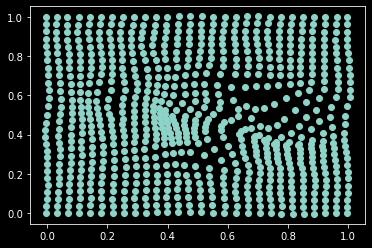

In [101]:
plt.scatter(phi1[N, 0], phi1[N, 1])

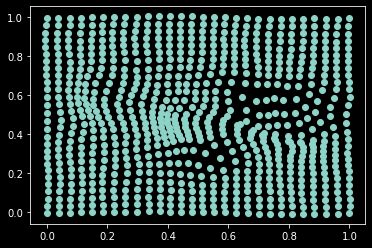

In [102]:
plt.scatter(phi2[N, 0], phi2[N, 1])

In [94]:
ident_hope = py_utils.compute_warped_image_multiNC(phi1, phi2, net.spacing, 1)

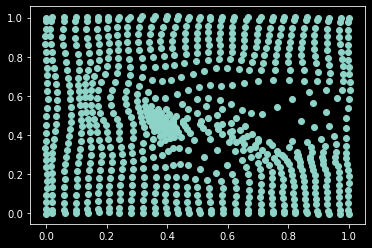

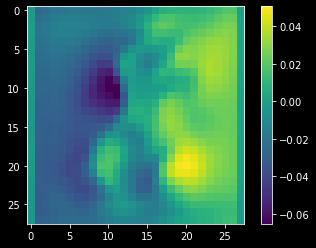

In [96]:
plt.imshow(ident_hope[N, 1] - iden[N, 1])
plt.colorbar()

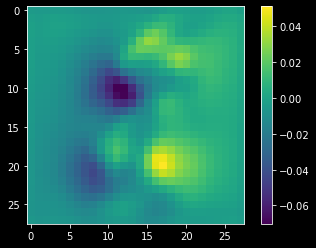

In [98]:
plt.imshow(phi2[N, 1] - iden[N, 1])
plt.colorbar()

In [27]:
net.phi.size()

torch.Size([128, 2, 28, 28])